In [1]:
import utils
import os
import numpy as np
import numpy.linalg as la
import glob
import cv2
import utils
import pylab as pl
import shutil
import matplotlib.cm as cm
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/ipykernel/.*')
%matplotlib inline

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set f

In [2]:
# Also load the non-filtered data for evaluation
_d = np.load('../data/data_128_train.npz')
X_train = _d['X'][:,None,:,:]
Y_train = _d['Y'][:,None,:,:]

In [3]:
_d = np.load('../data/data_128_test.npz')
X_test = _d['X']

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/matplotlib/transforms.py:2764: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  elif vmax - vmin <= maxabsvalue * tiny:


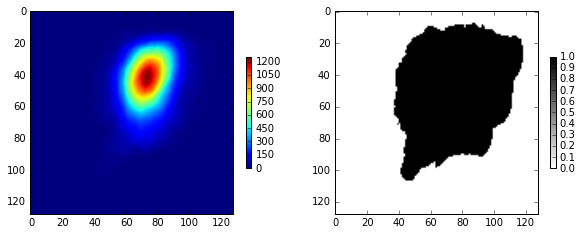

In [4]:
avg_mask = np.sum(Y_train.squeeze(), axis=0)
pl.figure(figsize=(10, 4))
pl.subplot(121)
pl.imshow(avg_mask)
pl.colorbar(shrink=0.5)
pl.subplot(122)
pl.imshow(avg_mask > 3, cmap=cm.binary)
pl.colorbar(shrink=0.5)

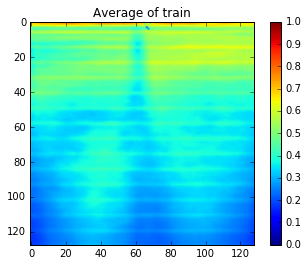

In [5]:
pl.title('Average of train')
pl.imshow(np.mean(X_train.squeeze(), axis=0), vmin=0, vmax=1)
pl.colorbar()

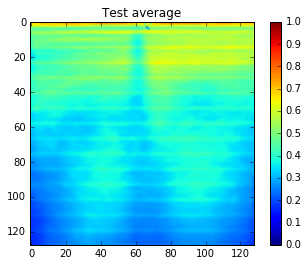

In [6]:
pl.title('Test average')
pl.imshow(np.mean(X_test.squeeze(), axis=0), vmin=0, vmax=1)
pl.colorbar()

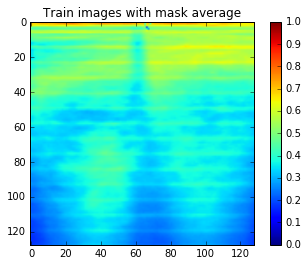

In [8]:
Y_train_binary = np.any(Y_train.reshape(-1, 128 * 128), axis=1)

pl.title('Train images with mask average')
pl.imshow(np.mean(X_train[Y_train_binary].squeeze(), axis=0), vmin=0, vmax=1)
pl.colorbar()

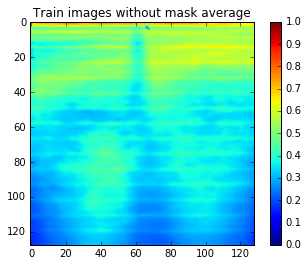

In [9]:
Y_train_binary = np.any(Y_train.reshape(-1, 128 * 128), axis=1)

pl.title('Train images without mask average')
pl.imshow(np.mean(X_train[Y_train_binary].squeeze(), axis=0), vmin=0, vmax=1)
pl.colorbar()

# Percent of images with mask in train

In [10]:
print "%.2f%% with masks" % (100 * np.count_nonzero(Y_train_binary) / float(len(Y_train_binary)))

41.22% with masks


# Ellipse fit

Ellipse fit from https://www.kaggle.com/bguberfain/ultrasound-nerve-segmentation/ellipse-fit

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


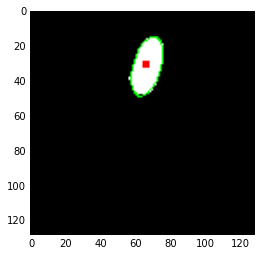

In [11]:
import skimage

def plot_image(img, title=None):
    plt.figure(figsize=(15,20))
    plt.title(title)
    plt.imshow(img)
    plt.show()
    
# Draw elipsis on image
def draw_ellipse(mask):
    mask = skimage.img_as_ubyte(mask.squeeze())
    ret, thresh = cv2.threshold(mask, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, 1, 2)
    m3 = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    has_ellipse = len(contours) > 0
    ellipse = None
    if has_ellipse:
        cnt = contours[0]
        ellipse = cv2.fitEllipse(cnt)
        cx, cy = np.array(ellipse[0], dtype=np.int)
        m3[cy-2:cy+2,cx-2:cx+2] = (255, 0, 0)
        cv2.ellipse(m3, ellipse, (0, 255, 0), 1)
        
    return has_ellipse, ellipse, m3

has_ellipse, ellipse, img = draw_ellipse(Y_train[Y_train_binary][501])
pl.imshow(img)

In [12]:
(cx, cy), (lx, ly), angle = ellipse
angle = np.deg2rad(angle)

In [13]:
ellipse

((66.13404083251953, 31.745372772216797),
 (15.767712593078613, 34.955474853515625),
 16.250478744506836)

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


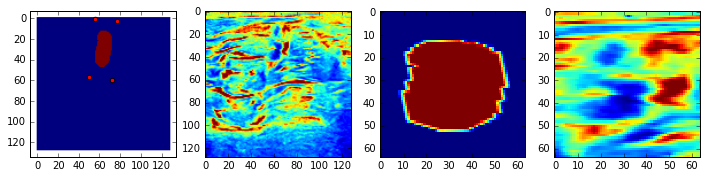

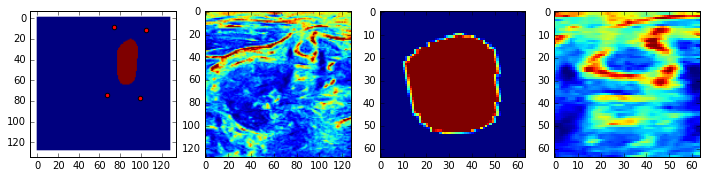

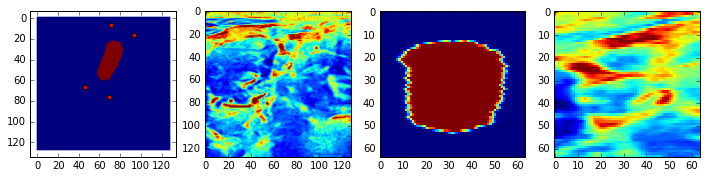

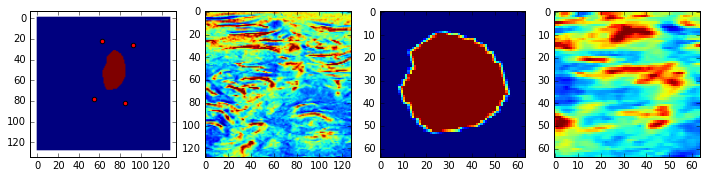

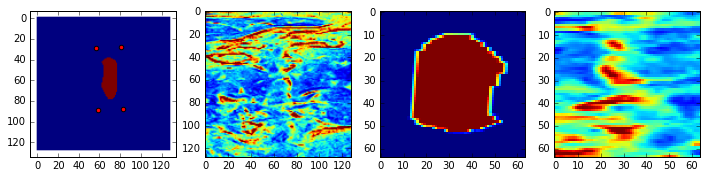

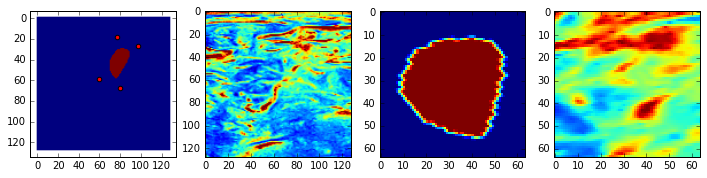

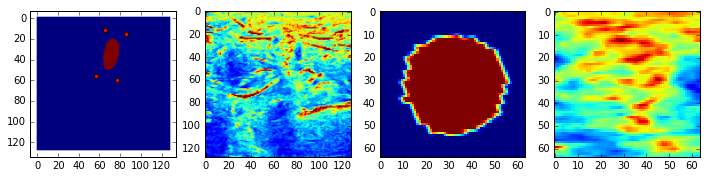

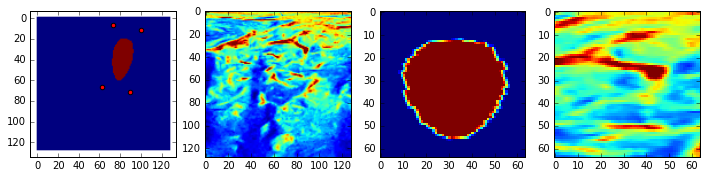

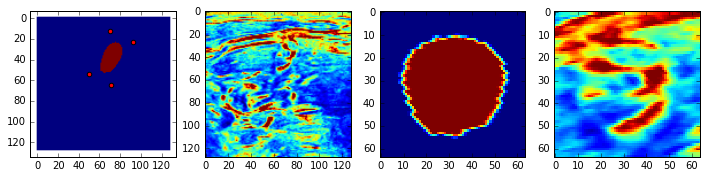

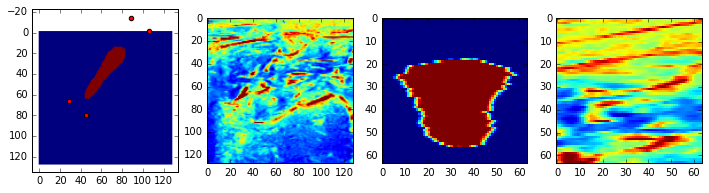

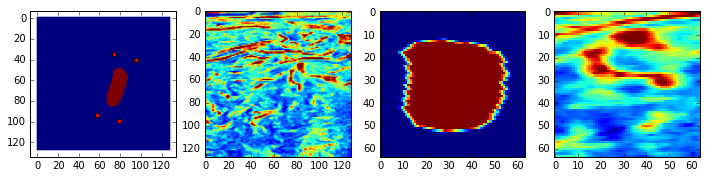

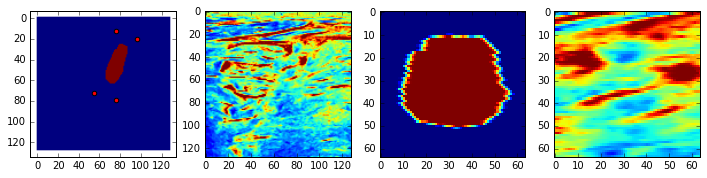

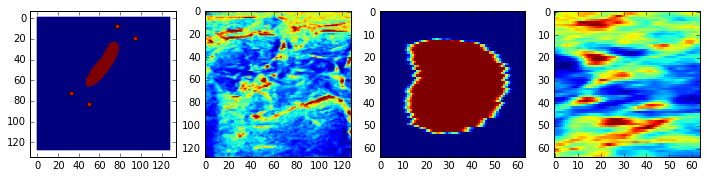

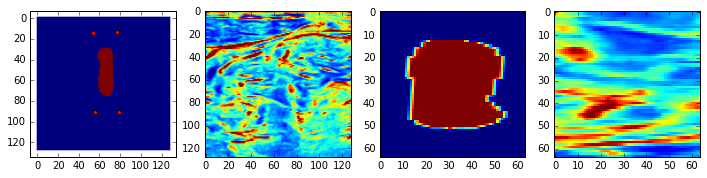

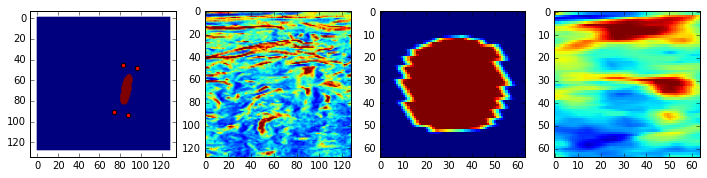

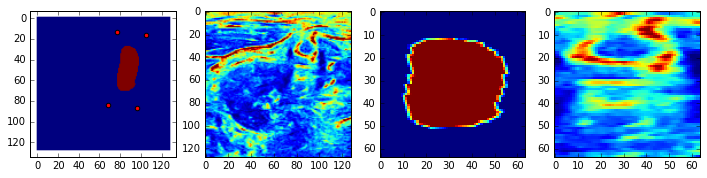

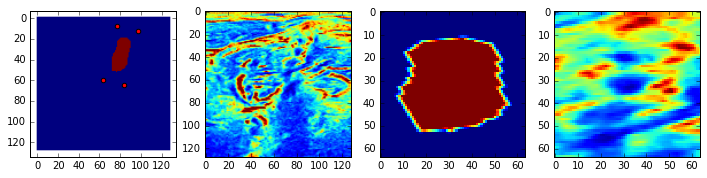

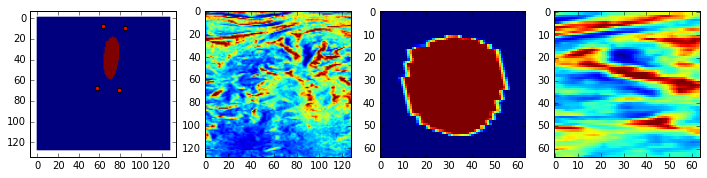

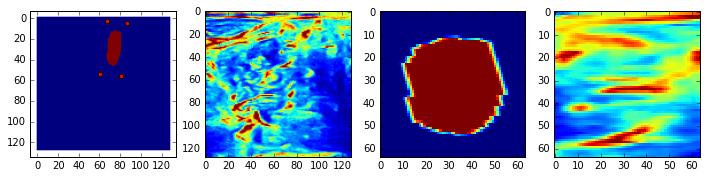

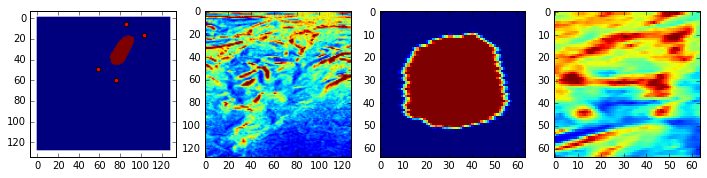

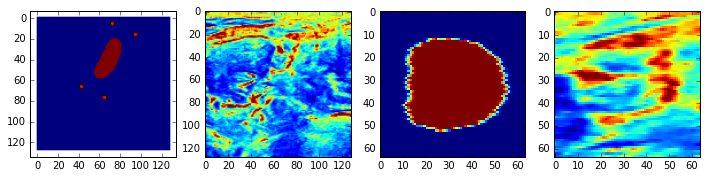

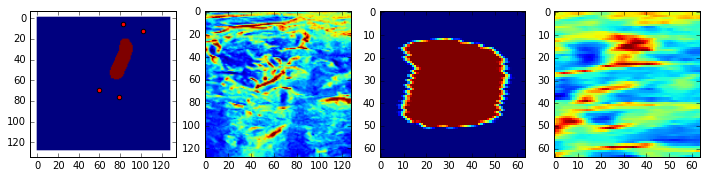

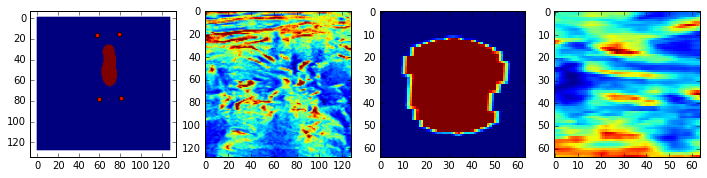

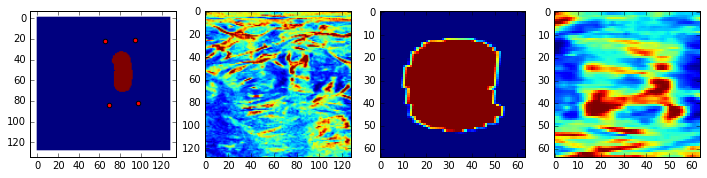

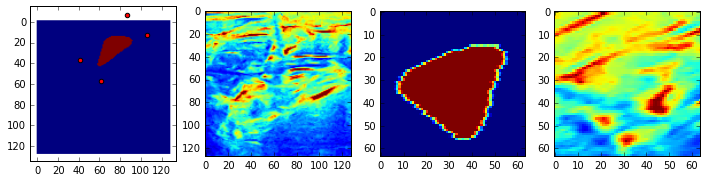

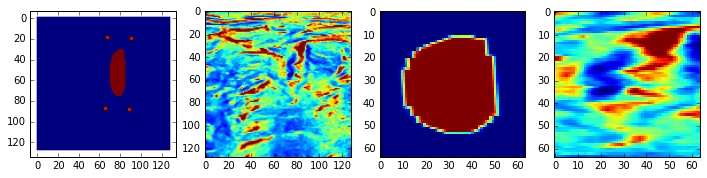

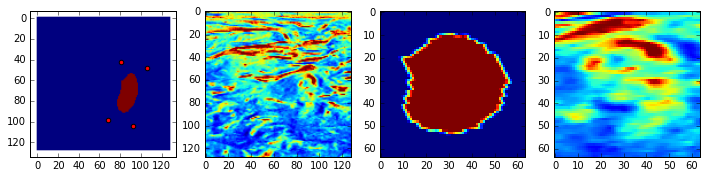

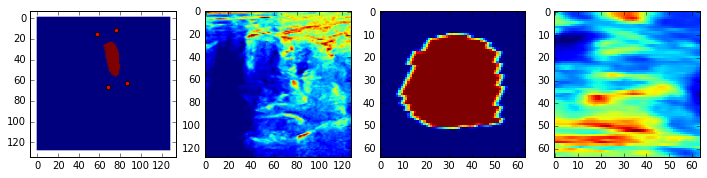

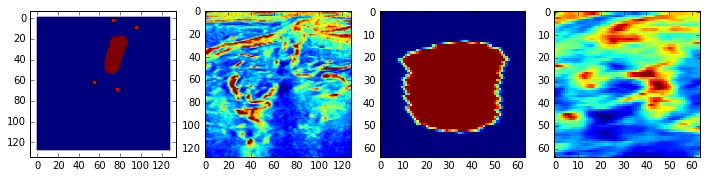

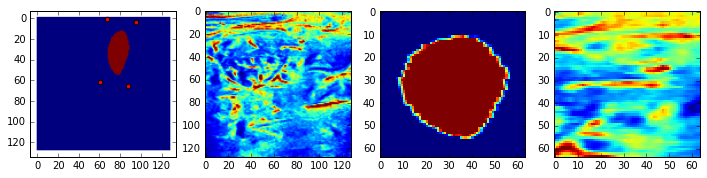

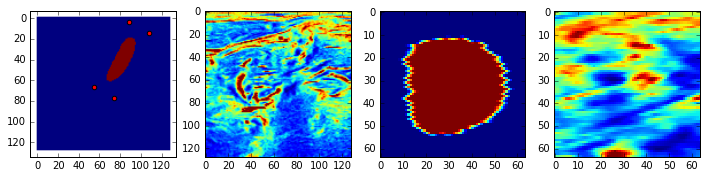

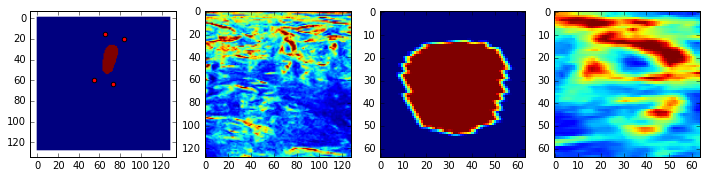

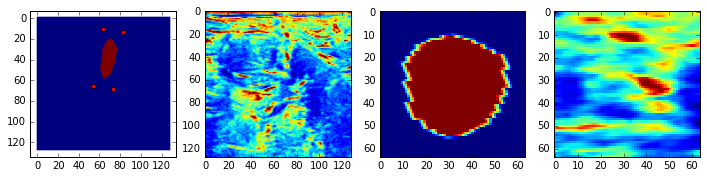

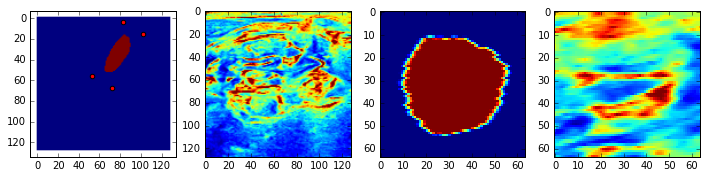

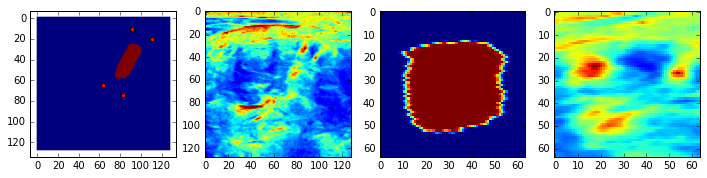

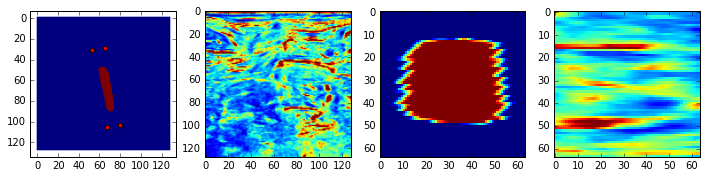

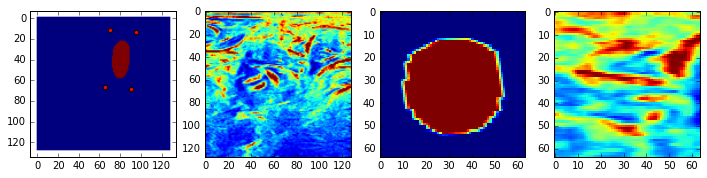

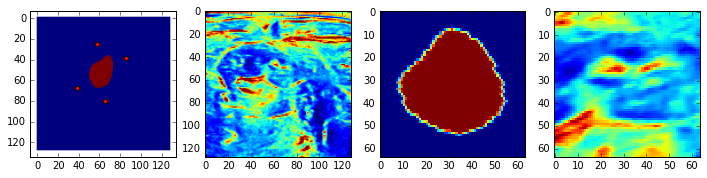

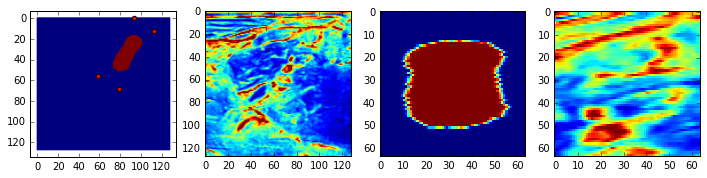

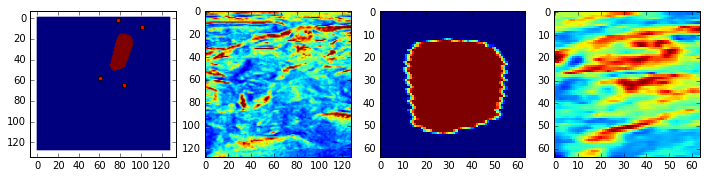

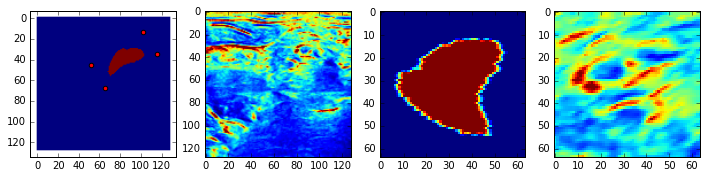

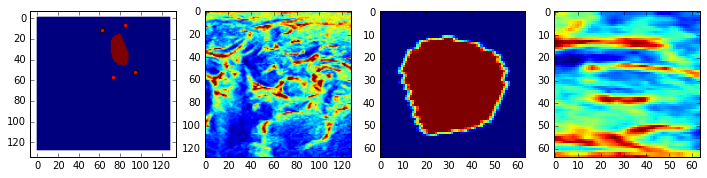

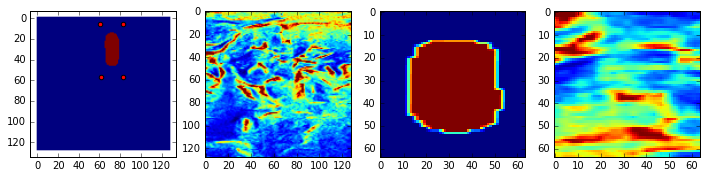

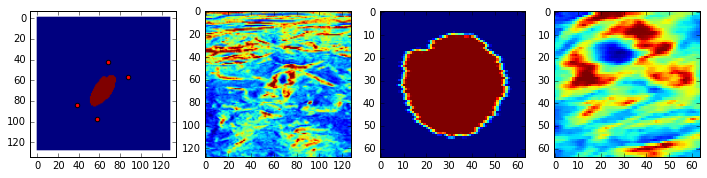

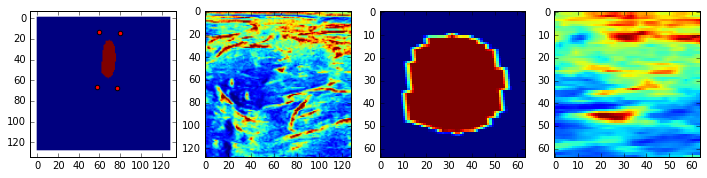

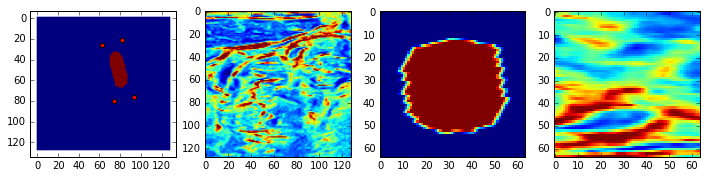

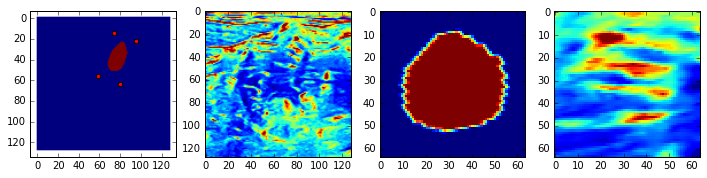

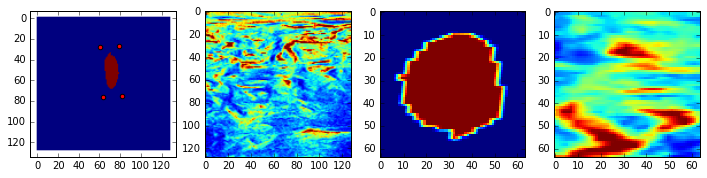

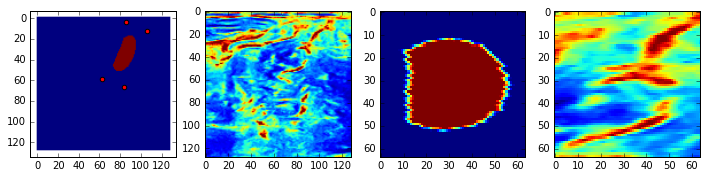

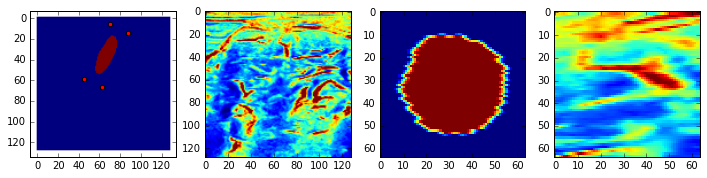

In [14]:
def zoom_on_rectified_mask(X, Y):
    """
    This fits an ellipse to the mask and then rectify the mask area
    so that it fits in a rectangle (basically undoes to rotation)
    """
    has_ellipse, ellipse, img = draw_ellipse(Y)
    X, Y = X.squeeze(), Y.squeeze()
    
    if not has_ellipse:
        return
    
    (cx, cy), (lx, ly), angle = ellipse
    angle = np.deg2rad(angle)
    
    hx = lx / 2.0
    hy = ly / 2.0
    margin = 1.5
    # the ellipse oriented bounding box
    pts1 = np.array([(-margin * hx, -margin * hy), (-margin * hx, margin * hy),
                     (margin * hx, -margin * hy), (margin * hx, margin * hy)])
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle), np.cos(angle)]])
    pts1 = R.dot(pts1.T).T
    pts1 += (cx, cy)
    pts1 = pts1.astype(np.float32)

    # we want the ellipse to fit in a 64 x 64 square
    pts2 = np.array([(0, 0), (0, 64), (64, 0), (64, 64)])
    pts2 = pts2.astype(np.float32)

    # need only 3 points to define affine transform
    M = cv2.getAffineTransform(pts1[:3], pts2[:3])
    Yr = cv2.warpAffine(Y, M, (64, 64), flags=cv2.INTER_LINEAR,
                        borderMode=cv2.BORDER_REFLECT_101)
    Xr = cv2.warpAffine(X, M, (64, 64), flags=cv2.INTER_LINEAR,
                        borderMode=cv2.BORDER_REFLECT_101)

    (xmin, ymin), (xmax, ymax) = pts2.min(axis=0).round().astype(np.int), pts2.max(axis=0).round().astype(np.int)
    
    pl.figure(figsize=(12, 4))
    pl.subplot(141)
    pl.imshow(Y)
    pl.scatter(pts1[:,0], pts1[:,1], c='r')
    pl.subplot(142)
    pl.imshow(X, vmin=0, vmax=1)
    pl.subplot(143)
    pl.imshow(Yr[ymin:ymax, xmin:xmax], vmin=0, vmax=1, interpolation='nearest')
    pl.subplot(144)
    pl.imshow(Xr[ymin:ymax, xmin:xmax], vmin=0, vmax=1, interpolation='nearest')
    
#i = 501
for i in np.random.choice(np.flatnonzero(Y_train_binary), 50):
    zoom_on_rectified_mask(X_train[i], Y_train[i])

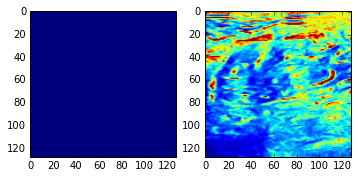

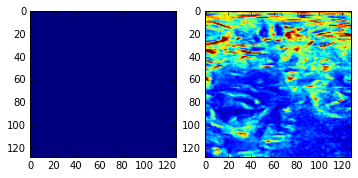

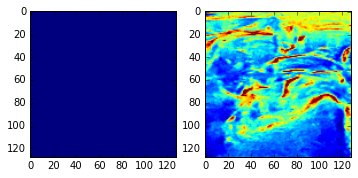

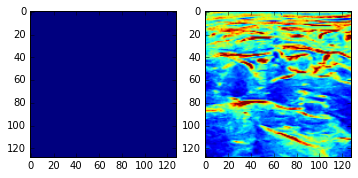

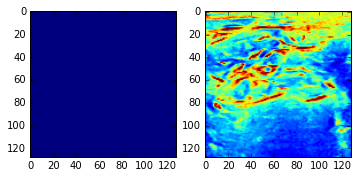

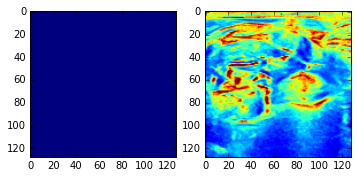

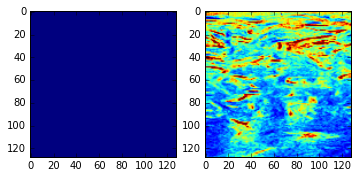

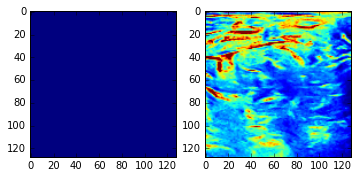

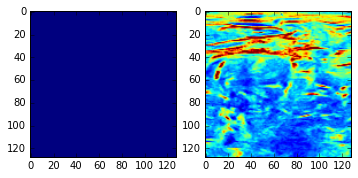

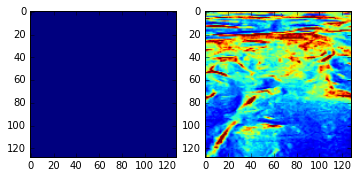

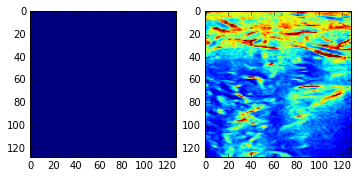

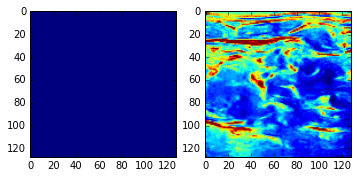

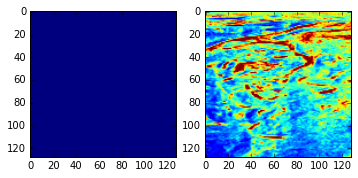

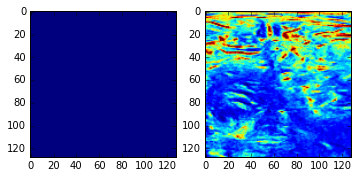

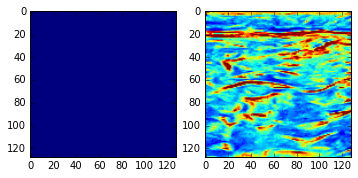

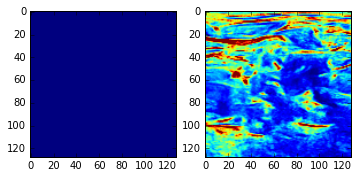

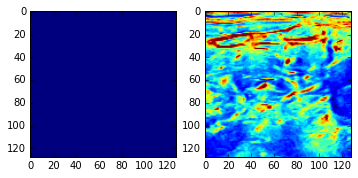

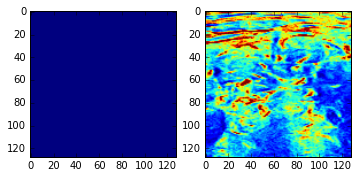

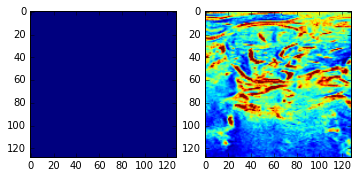

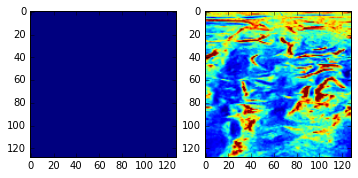

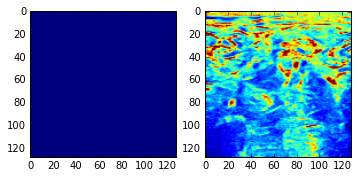

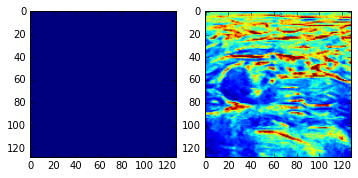

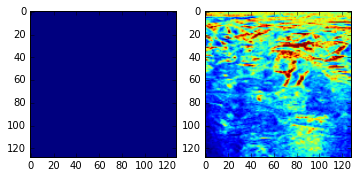

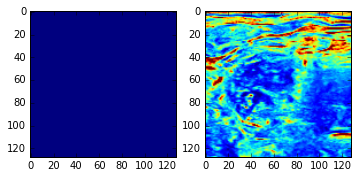

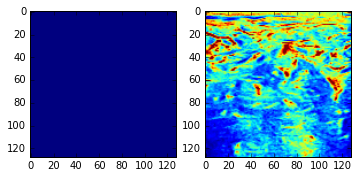

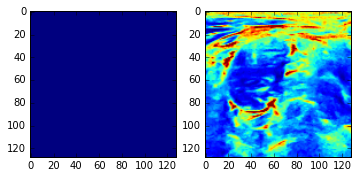

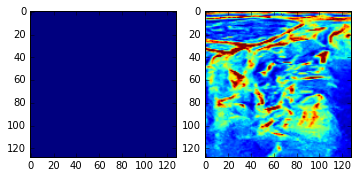

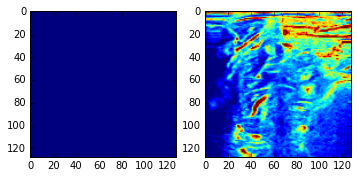

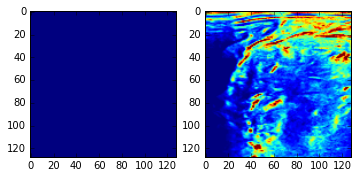

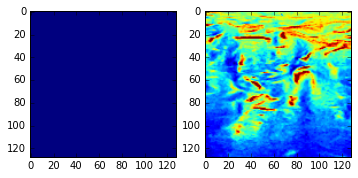

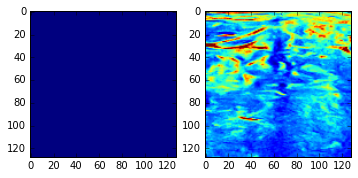

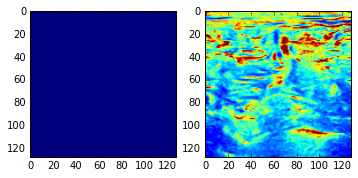

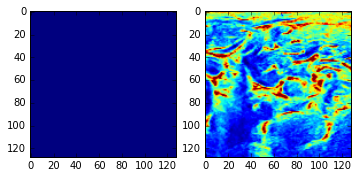

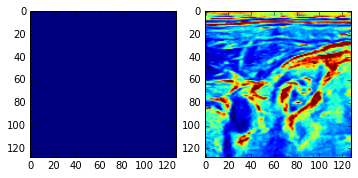

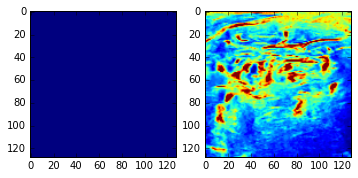

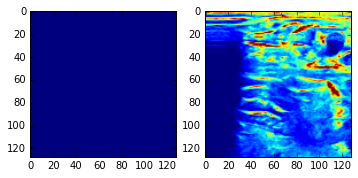

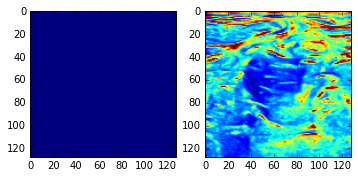

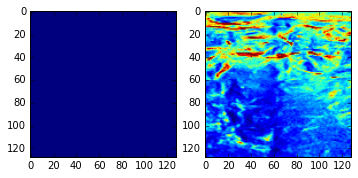

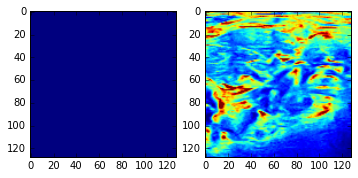

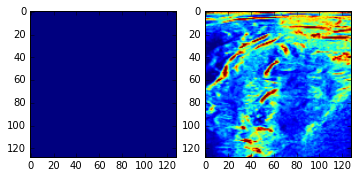

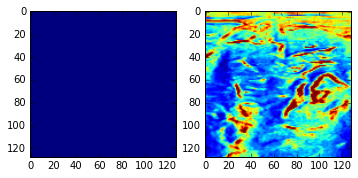

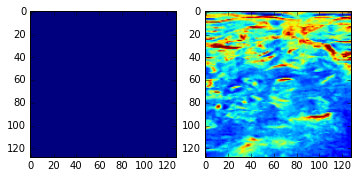

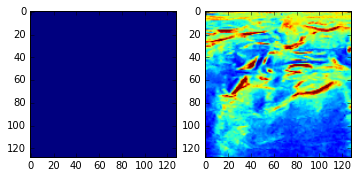

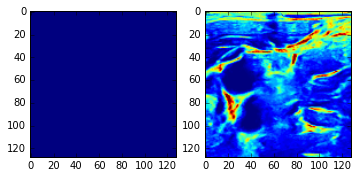

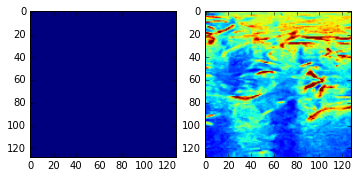

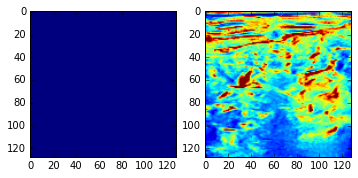

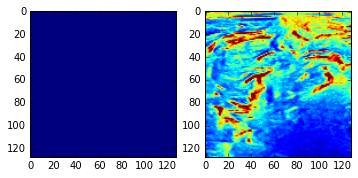

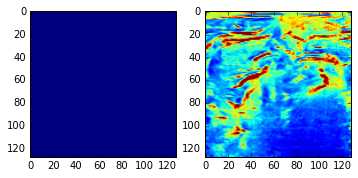

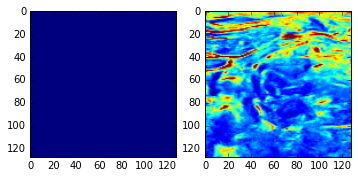

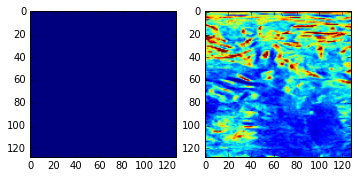

In [18]:
for i in np.random.choice(np.flatnonzero(~Y_train_binary), 50):
    pl.figure(figsize=(12, 4))
    pl.subplot(141)
    pl.imshow(Y_train[i].squeeze())
    pl.subplot(142)
    pl.imshow(X_train[i].squeeze(), vmin=0, vmax=1)

# Stats on our predictions

In [38]:
def load_preds():
    PRED_DIR='../../preds'

    test_fnames = ['%d.png' % i for i in range(1,5509)]
    Y_pred = [cv2.imread(os.path.join(PRED_DIR, fname), cv2.IMREAD_GRAYSCALE) for fname in test_fnames]
    return np.array(Y_pred)
Y_pred = load_preds()

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/matplotlib/transforms.py:2764: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  elif vmax - vmin <= maxabsvalue * tiny:


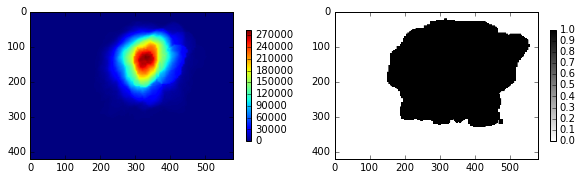

In [39]:
avg_pred = np.sum(Y_pred.squeeze(), axis=0)
pl.figure(figsize=(10, 4))
pl.subplot(121)
pl.imshow(avg_pred)
pl.colorbar(shrink=0.5)
pl.subplot(122)
pl.imshow(avg_pred > 3, cmap=cm.binary)
pl.colorbar(shrink=0.5)

In [44]:
Y_pred_binary = np.any(Y_pred.reshape(-1, 420 * 580), axis=1)

In [45]:
print "%.2f%% with masks in pred" % (100 * np.count_nonzero(Y_pred_binary) / float(len(Y_pred_binary)))

38.51% with masks in pred
